### Objective: In this notebook, I am developing/testing code for using the RSA method of hydrophobicity. 

A simpler way that has been documented in the literature is to sum up the relative surface accesibility of Hydrophobicity by residue. 

### load modules 

In [1]:
%load_ext autoreload

from pathlib import Path
import pandas as pd
import numpy as np
from dask import delayed, compute
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley
from tqdm.notebook import tqdm
import seaborn as sns

from developability.utils import ls, extract_sequence_from_pdb
from developability.descriptors import map3to1
from developability.hydrophobicity import read_hydrophobicity_scales, load_hydrophobicity_scale,region_hydrophobicities
from developability.descriptors import annotate_residues_with_fv_regions

In [2]:
sasas = {
            'ALA'   :   121.0,
            'ARG'   :   265.0,
            'ASN'   :   187.0,
            'NLN'   :   187.0,
            'ASP'   :   187.0,
            'CYS'   :   148.0,
            'CYX'   :   148.0,
            'GLU'   :   214.0,
            'GLN'   :   214.0,
            'GLY'   :   97.0,
            'HIS'   :   216.0,
            'HIE'   :   216.0,
            'HID'   :   216.0,
            'HIP'   :   216.0,
            'ILE'   :   195.0,
            'LEU'   :   191.0,
            'LYS'   :   230.0,
            'MET'   :   203.0,
            'PHE'   :   228.0,
            'PRO'   :   154.0,
            'SER'   :   143.0,
            'THR'   :   163.0,
            'TRP'   :   264.0,
            'TYR'   :   255.0,
            'VAL'   :   165.0
        }

In [3]:
base_path = Path("/Users/ChristopherRivera/Documents/DataResults")
data_path = base_path /"TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures"

pdb = data_path /'ramucirumab.pdb'

In [4]:
scales = read_hydrophobicity_scales()
scales.columns

Index(['amino_acid_name', 'Residue', 'Kyte_Doolittle', 'Hopp_Woods',
       'Cornette', 'Eisenberg', 'Rose', 'Janin', 'Engelman_GES', 'BaMe',
       'BlMo', 'Ei', 'KyDo', 'Me', 'Ro', 'WiWh', 'Ja', 'Mi'],
      dtype='object')

In [5]:
def compute_rsa_hydrophobicity(pdb, scale): 
    """Uses rsa method to compute hydrophobicity. Need to add reference for this method. 

    Args:
        pdb (str|Path): path to the pdb file
        scale (str): hydrophobicity scale to use

    Returns:
        pandas.DataFrame: dataframe with hydrophobicity values
    """

    # load pdb structure
    p = PDBParser()
    struct = p.get_structure("ab", pdb)
    
    # compute sasa using ShrakeRupley method
    sr = ShrakeRupley()
    sr.compute(struct, level="R")

    # load hydrophobicity scale and map to 3-letter amino acid code
    scale = load_hydrophobicity_scale(scale)
    residues = list(struct.get_residues())

    df = [(residue.get_resname(), residue.sasa) for residue in residues]
    df = pd.DataFrame(df, columns=["Residue_name", "sasa"])
    df.insert( 1,'aa', map3to1(df['Residue_name'].values))
    df['max_sasa'] = df['Residue_name'].map(sasas)
    
    # compute hydrophobicity using rsa method
    df['rsa']=df['sasa']/df['max_sasa']
    df['hydrophobicity_raw'] = df['aa'].map(scale)
    df['Hydrophobicity'] = df['hydrophobicity_raw']*df['rsa']

    return df


def compute_rsa_hydrophobicity_for_ab(pdb, scale, save_path=None, save=False, name=None): 
    """Computes rsa hydrophobicity for an antibody pdb file."""
    
    rsa_hydro_df = compute_rsa_hydrophobicity(pdb, scale)
    sequences = extract_sequence_from_pdb(pdb)
    rsa_hydro_df = annotate_residues_with_fv_regions(sequences, rsa_hydro_df, scheme = 'kabat')

    if save:
        if not save_path: 
            save_path = pdb.parent 
            
        f = save_path/ f"rsa_hydrophobicity_scale_{scale}.csv"
        rsa_hydro_df.to_csv(f, index=False)
    
    if not name: 
        name = pdb.stem
    rsa_hydro_descriptors = pd.DataFrame(region_hydrophobicities(rsa_hydro_df), index=[name])
    rsa_hydro_descriptors.index.name = 'antibody'
    return rsa_hydro_descriptors



def parallelize_rsa_hydrophobicity(paths, scale):
    dfs = []
    batches = np.array_split(paths,10)
    for batch in tqdm(batches, total = len(batches)):
        tasks  = [delayed(compute_rsa_hydrophobicity_for_ab)(path/'pdb4amber.pdb', scale, name = path.name.split('_')[0], save=True) for path in batch]
        dfs.extend([task for task in compute(*tasks, scheduler='processes')])
        
    df = pd.concat(dfs)
    df['scale'] = scale

    output_path = paths[0].parent
    df.to_csv(output_path/f'rsa_hydrophobicity_scale_{scale}.csv')
    return df

In [6]:
res = compute_rsa_hydrophobicity(pdb, "Ja")
res.head()

,Residue_name,aa,sasa,max_sasa,rsa,hydrophobicity_raw,Hydrophobicity
0,GLU,E,203.209045,214.0,0.949575,0.46,0.436804
1,VAL,V,62.219469,165.0,0.377088,0.97,0.365775
2,GLN,Q,85.591222,214.0,0.399959,-0.72,-0.287970
3,LEU,L,6.834296,191.0,0.035782,1.54,0.055104
4,VAL,V,82.038998,165.0,0.497206,0.97,0.482290


In [7]:
rsa = compute_rsa_hydrophobicity_for_ab(pdb, "Ja",save=True)
rsa

,HCDR1_HYDRO_pos,HCDR1_HYDRO_neg,HCDR1_HYDRO_net,HCDR2_HYDRO_pos,HCDR2_HYDRO_neg,HCDR2_HYDRO_net,HCDR3_HYDRO_pos,HCDR3_HYDRO_neg,HCDR3_HYDRO_net,HFR1_HYDRO_pos,...,LC_HYDRO_net,TOTAL_CDR_HYDRO_pos,TOTAL_CDR_HYDRO_neg,TOTAL_CDR_HYDRO_net,TOTAL_FR_HYDRO_pos,TOTAL_FR_HYDRO_neg,TOTAL_FR_HYDRO_net,TOTAL_HYDRO_pos,TOTAL_HYDRO_neg,TOTAL_HYDRO_net
antibody,,,,,,,,,,,,,,,,,,,,,
ramucirumab,0.579719,0.0,0.579719,3.01792,-0.758435,2.259485,0.62511,-0.232543,0.392567,3.587726,...,4.259563,7.415891,-2.059974,5.355917,12.157793,-7.61266,4.545132,19.573684,-9.672635,9.90105


In [8]:
paths = [d for d in ls(data_path) if d.is_dir() and d.name.endswith('outputs')]


In [9]:
scales_ = ['Kyte_Doolittle', 'Eisenberg', 'Rose', 'BaMe','BlMo', 'Ei', 'KyDo', 'Me', 'Ro', 'WiWh', 'Ja', 'Mi']

for scale in tqdm(scales_, total = len(scales_)):
    print(scale)
    parallelize_rsa_hydrophobicity(paths, scale)

  0%|          | 0/12 [00:00<?, ?it/s]

Kyte_Doolittle


  0%|          | 0/10 [00:00<?, ?it/s]

Eisenberg


  0%|          | 0/10 [00:00<?, ?it/s]

Rose


  0%|          | 0/10 [00:00<?, ?it/s]

BaMe


  0%|          | 0/10 [00:00<?, ?it/s]

BlMo


  0%|          | 0/10 [00:00<?, ?it/s]

Ei


  0%|          | 0/10 [00:00<?, ?it/s]

KyDo


  0%|          | 0/10 [00:00<?, ?it/s]

Me


  0%|          | 0/10 [00:00<?, ?it/s]

Ro


  0%|          | 0/10 [00:00<?, ?it/s]

WiWh


  0%|          | 0/10 [00:00<?, ?it/s]

Ja


  0%|          | 0/10 [00:00<?, ?it/s]

Mi


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
files = [f for f in ls(data_path) if 'rsa' in f.name and f.name.endswith('.csv')]
files

[PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/rsa_hydrophobicity_scale_WiWh.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/rsa_hydrophobicity_scale_BlMo.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/rsa_hydrophobicity_scale_Mi.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/rsa_hydrophobicity_scale_Ro.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/rsa_hydrophobicity_scale_BaMe.csv'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/rsa_hydrophobicity_scale_KyDo.csv'),
 PosixPath('/Users/Christo

In [11]:
df = pd.concat([pd.read_csv(f) for f in files])
df = df.set_index('antibody').sort_index()
df.head()

,HCDR1_HYDRO_pos,HCDR1_HYDRO_neg,HCDR1_HYDRO_net,HCDR2_HYDRO_pos,HCDR2_HYDRO_neg,HCDR2_HYDRO_net,HCDR3_HYDRO_pos,HCDR3_HYDRO_neg,HCDR3_HYDRO_net,HFR1_HYDRO_pos,...,TOTAL_CDR_HYDRO_pos,TOTAL_CDR_HYDRO_neg,TOTAL_CDR_HYDRO_net,TOTAL_FR_HYDRO_pos,TOTAL_FR_HYDRO_neg,TOTAL_FR_HYDRO_net,TOTAL_HYDRO_pos,TOTAL_HYDRO_neg,TOTAL_HYDRO_net,scale
antibody,,,,,,,,,,,,,,,,,,,,,
abituzumab,1.158171,-0.047080,1.111091,1.039075,-2.250825,-1.211749,0.707422,-0.344297,0.363125,0.812412,...,4.561561,-5.409205,-0.847643,2.293206,-21.667242,-19.374036,6.854767,-27.076447,-20.221680,WiWh
abituzumab,0.975470,-0.506023,0.469447,2.750974,-11.665356,-8.914382,1.259148,-2.913764,-1.654616,5.481614,...,7.680679,-26.936257,-19.255577,15.656790,-67.957901,-52.301110,23.337469,-94.894157,-71.556688,Kyte_Doolittle
abituzumab,0.383220,-0.092095,0.291126,1.027320,-3.375997,-2.348677,0.480563,-0.755429,-0.274866,2.109592,...,2.926067,-7.509856,-4.583789,5.989721,-17.990701,-12.000980,8.915788,-25.500557,-16.584769,KyDo
abituzumab,0.644011,-0.056496,0.587515,1.269665,-3.877525,-2.607861,0.926520,-1.035592,-0.109072,2.853075,...,4.106959,-8.351595,-4.244635,8.290182,-17.420809,-9.130627,12.397142,-25.772404,-13.375262,Eisenberg
abituzumab,0.350626,-0.213430,0.137196,0.563256,-5.881043,-5.317787,0.216953,-1.385298,-1.168345,0.794740,...,1.723525,-13.407667,-11.684142,2.470376,-32.926676,-30.456300,4.193901,-46.334343,-42.140443,Ei


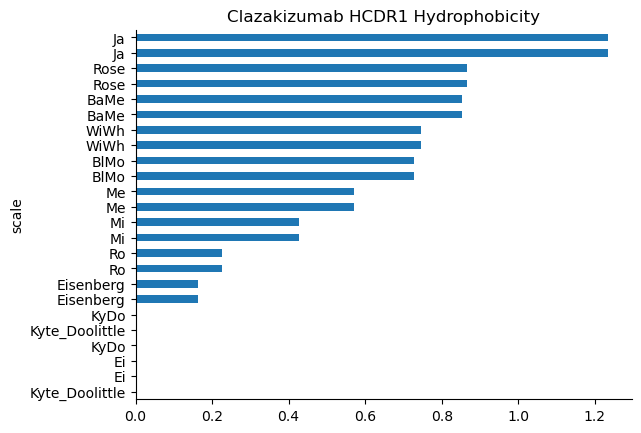

In [12]:

df.loc['clazakizumab'].set_index('scale')['HCDR1_HYDRO_pos'].sort_values().plot.barh(title= 'Clazakizumab HCDR1 Hydrophobicity')
sns.despine()

### save to csv

In [13]:
fname = data_path.parent/'rsa_hydrophobicity_descriptors_12-05-2023.csv'
df.to_csv(fname)

## Now compute SASA hydrophobicity 
Note analysis performed on 12-11-2023. 

In [14]:
def compute_sasa_hydrophobicity_for_ab(pdb, scale, save=False, name=None): 
    """Computes sasa hydrophobicity for an antibody pdb file."""
    
    save_path = pdb.parent

    rsa_f = save_path/ f"rsa_hydrophobicity_scale_{scale}.csv"
    if not rsa_f.exists(): 
        hydro_df = compute_rsa_hydrophobicity(pdb, scale)
        sequences = extract_sequence_from_pdb(pdb)
        hydro_df = annotate_residues_with_fv_regions(sequences, hydro_df, scheme = 'kabat')
    else: 
        hydro_df = pd.read_csv(rsa_f)

    if save and not rsa_f.exists():

            
        f = save_path/ f"rsa_hydrophobicity_scale_{scale}.csv"
        hydro_df.to_csv(f, index=False)
    
    if not name: 
        name = pdb.stem
    sasa_hydro_descriptors = pd.DataFrame(region_hydrophobicities(hydro_df, hydrophobicity_col= 'hydrophobicity_raw'), index=[name])
    sasa_hydro_descriptors.index.name = 'antibody'
    return sasa_hydro_descriptors


def parallelize_sasa_hydrophobicity(paths, scale):
    dfs = []
    batches = np.array_split(paths,10)
    for batch in tqdm(batches, total = len(batches)):
        tasks  = [delayed(compute_sasa_hydrophobicity_for_ab)(path/'pdb4amber.pdb', scale, name = path.name.split('_')[0], save=True) for path in batch]
        dfs.extend([task for task in compute(*tasks, scheduler='processes')])
        
    df = pd.concat(dfs)
    df['scale'] = scale

    output_path = paths[0].parent
    df.to_csv(output_path/f'sasa_hydrophobicity_scale_{scale}.csv')
    return df

In [15]:
scales_ = ['Kyte_Doolittle', 'Eisenberg', 'Rose', 'BaMe','BlMo', 'Ei', 'KyDo', 'Me', 'Ro', 'WiWh', 'Ja', 'Mi']

for scale in tqdm(scales_, total = len(scales_)):
    print(scale)
    parallelize_sasa_hydrophobicity(paths, scale)

  0%|          | 0/12 [00:00<?, ?it/s]

Kyte_Doolittle


  0%|          | 0/10 [00:00<?, ?it/s]

Eisenberg


  0%|          | 0/10 [00:00<?, ?it/s]

Rose


  0%|          | 0/10 [00:00<?, ?it/s]

BaMe


  0%|          | 0/10 [00:00<?, ?it/s]

BlMo


  0%|          | 0/10 [00:00<?, ?it/s]

Ei


  0%|          | 0/10 [00:00<?, ?it/s]

KyDo


  0%|          | 0/10 [00:00<?, ?it/s]

Me


  0%|          | 0/10 [00:00<?, ?it/s]

Ro


  0%|          | 0/10 [00:00<?, ?it/s]

WiWh


  0%|          | 0/10 [00:00<?, ?it/s]

Ja


  0%|          | 0/10 [00:00<?, ?it/s]

Mi


  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
files = [f for f in ls(data_path) if 'sasa' in f.name and f.name.endswith('.csv')]
df2 = pd.concat([pd.read_csv(f) for f in files])
df2 = df2.set_index('antibody').sort_index()
df2.head()

,HCDR1_HYDRO_pos,HCDR1_HYDRO_neg,HCDR1_HYDRO_net,HCDR2_HYDRO_pos,HCDR2_HYDRO_neg,HCDR2_HYDRO_net,HCDR3_HYDRO_pos,HCDR3_HYDRO_neg,HCDR3_HYDRO_net,HFR1_HYDRO_pos,...,TOTAL_CDR_HYDRO_pos,TOTAL_CDR_HYDRO_neg,TOTAL_CDR_HYDRO_net,TOTAL_FR_HYDRO_pos,TOTAL_FR_HYDRO_neg,TOTAL_FR_HYDRO_net,TOTAL_HYDRO_pos,TOTAL_HYDRO_neg,TOTAL_HYDRO_net,scale
antibody,,,,,,,,,,,,,,,,,,,,,
abituzumab,4.49,-0.46,4.03,9.56,-2.34,7.22,4.51,-1.08,3.43,8.14,...,30.52,-12.11,18.41,68.68,-42.85,25.83,99.20,-54.96,44.24,Me
abituzumab,4.27,-0.53,3.74,5.34,-7.11,-1.77,4.28,-1.60,2.68,10.08,...,21.28,-20.26,1.02,59.91,-62.22,-2.31,81.19,-82.48,-1.29,Ro
abituzumab,5.33,0.00,5.33,11.68,-1.08,10.60,7.22,-0.52,6.70,19.45,...,41.22,-4.96,36.26,118.62,-18.86,99.76,159.84,-23.82,136.02,BaMe
abituzumab,1.23,-1.58,-0.35,2.57,-15.21,-12.64,1.64,-4.74,-3.10,4.21,...,8.91,-40.76,-31.85,24.96,-95.94,-70.98,33.87,-136.70,-102.83,Ei
abituzumab,4.06,-0.35,3.71,5.70,-5.65,0.05,3.63,-2.14,1.49,4.35,...,19.80,-21.45,-1.65,36.73,-66.59,-29.86,56.53,-88.04,-31.51,WiWh


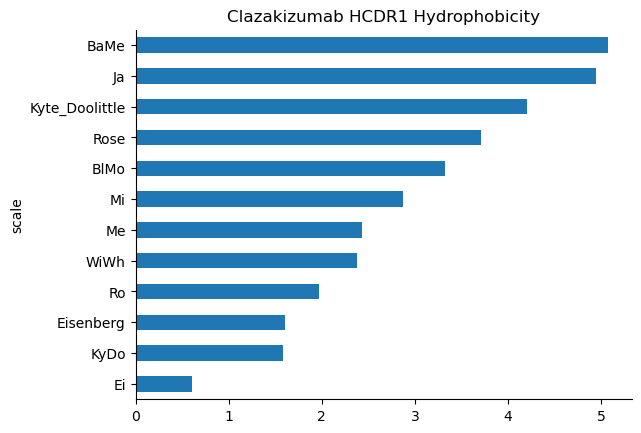

In [23]:

df2.loc['clazakizumab'].set_index('scale')['HCDR1_HYDRO_pos'].sort_values().plot.barh(title= 'Clazakizumab HCDR1 Hydrophobicity')
sns.despine()

In [25]:
fname = data_path.parent/'sasa_hydrophobicity_descriptors_12-11-2023.csv'
df2.to_csv(fname)